# Abalone Shell Data: Linear Models

<br />
<br />
<br />

### Table of Contents

* [Introduction](#intro)
* Linear models with scikit-learn
 * [scikit-learn: Linear Regression](#scikit_linear_regression)
 * [scikit-learn: Linear Regression Residuals](#scikit_linear_regresson_residuals)
 * [scikit-learn: Linear Regression with Transformed Variables](#scikit_linear_regresson_transformed)
 * [scikit-learn: Linear Regression with Quadratic Terms](#scikit_linear_regression_quadratic)
 * [scikit-learn: Ridge Regression](#scikit_ridge_regression)
* Linear models with StatsModels
 * [StatsModels: Linear Regression Model](#statsmodel_linear_model)
* More Advanced Linear Models with scikit-learn
 * [scikit-learn: Lasso with Cross-Validation](#lasso_regression)
 * [scikit-learn: Cross Validation by Hand](#scikit_cross_validation)
 * [scikit-learn: Lasso Lars Regression](#lasso_lars_regression)
 * [Scaling](#scaling)
 * [scikit-learn: Linear Support Vector Regression](#scikit_linear_svr)
* [Summary](#summary)
* [Next Steps](#next_steps)

<br />
<br />
<br />

<a name="intro"></a>
## Introduction

The abalone data set that we are analyzing is a data set with various physical measurements of sea snails. In this notebook we'll be constructing linear models to map from input variables to output variables, and see how well we are able to predict the number of rings in abalone shells.

In [1]:
%matplotlib inline

# ml
from sklearn import linear_model
from sklearn.model_selection import KFold

# numbers
import numpy as np
import pandas as pd

# stats
import statsmodels.api as sm
import scipy.stats as stats

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Copy-and-paste from prior notebook

def abalone_load(data_file, infant=False):
    # x data labels
    xnlabs = ['Sex']
    xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    xlabs = xnlabs + xqlabs

    # y data labels
    ylabs = ['Rings']

    # data
    df = pd.read_csv(data_file, header=None, sep=' ', names=xlabs+ylabs)
    
    if(infant):
        new_df = df[ df['Sex']=='I' ]
    else:
        new_df = df[ df['Sex']<>'I' ]
    return new_df

def infant_abalone_load(data_file):
    return abalone_load(data_file,True)

def adult_abalone_load(data_file):
    return abalone_load(data_file,False)

def abalone_removeoutliers(df,mse_tol,verbose=False):
    df.loc[:,'Volume'] = df['Length'].values*df['Diameter'].values*df['Height'].values

    X = df['Volume']
    Y = df['Shell weight']
    lin = sm.OLS(Y,X).fit()

    Yhat = lin.predict(df['Volume'])
    df.loc[:,'Predicted shell weight'] = Yhat
    df.loc[:,'Residual'] = Y - Yhat
    df.loc[:,'MSE'] = (Y - Yhat)**2
    MSE = df['MSE']

    thresh = 0.5
    new_df = df[df['MSE'] < thresh]
    records_removed = len(df) - len(new_df)
    
    if(verbose):
        print "Number of data points removed: %d"%(records_removed)
        print "%0.2f%% of data was removed"%((float(records_removed)/len(df))*100)
    
    del df['Predicted shell weight']
    del df['Residual']
    del df['MSE']
    
    return df

def infant_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,0.5)
    
def adult_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,1.0)

In [3]:
inf_df = infant_abalone_removeoutliers(infant_abalone_load('abalone/Dataset.data'))
adt_df = adult_abalone_removeoutliers(adult_abalone_load('abalone/Dataset.data'))

In [4]:
inf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342 entries, 4 to 4166
Data columns (total 10 columns):
Sex               1342 non-null object
Length            1342 non-null float64
Diameter          1342 non-null float64
Height            1342 non-null float64
Whole weight      1342 non-null float64
Shucked weight    1342 non-null float64
Viscera weight    1342 non-null float64
Shell weight      1342 non-null float64
Rings             1342 non-null int64
Volume            1342 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 115.3+ KB


In [5]:
adt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2835 entries, 0 to 4176
Data columns (total 10 columns):
Sex               2835 non-null object
Length            2835 non-null float64
Diameter          2835 non-null float64
Height            2835 non-null float64
Whole weight      2835 non-null float64
Shucked weight    2835 non-null float64
Viscera weight    2835 non-null float64
Shell weight      2835 non-null float64
Rings             2835 non-null int64
Volume            2835 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 243.6+ KB


From histograms of physical measurements, it was clear that infant abalones had more variance in their physical characteristics than adults, and that would make them harder to model. We'll start with linear models for adult abalones.

<a name="scikit_linear_regression"></a>
## scikit-learn: Linear Regression

A linear regression model for the abalones would predict the number of rings in an abalone shell as a linear function of the abalone's various physical measurements. Building a linear regression model is a good first step because it is one of the simplest models. Once we develop the model, we can determine how good a job it does, and whether we need a more sophisticated model.

The labels we'll be fitting the model to are the quantitative labels that are provided in the data set, while the system response being predicted is the number of rings in the shell:

In [6]:
# x data labels
xnlabs = ['Sex']
xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
xlabs = xnlabs + xqlabs

# y data labels
ylabs = ['Rings']

print xqlabs

['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']


In [7]:
print ylabs

['Rings']


In [8]:
lmreg = linear_model.LinearRegression( fit_intercept = False )
lmreg.fit( adt_df[xqlabs], adt_df[ylabs] )

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [9]:
lmreg.coef_

array([[  8.91404042,  12.22048227,  11.91342775,   8.72210978,
        -21.56383663, -12.44905461,   6.33154266]])

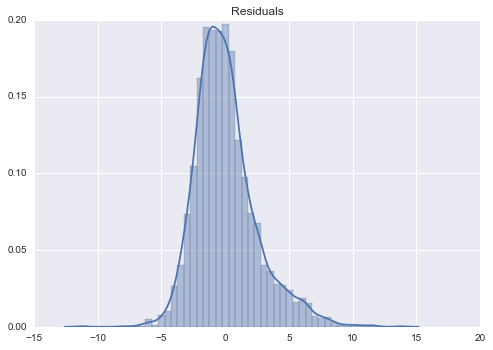

In [10]:
# Compute residuals 
yhat = lmreg.predict(adt_df[xqlabs])
lmresid = adt_df[ylabs] - yhat
sns.distplot(lmresid)
plt.title('Residuals')

plt.show()

Our model does a decent job of predicting the number of rings in the shell - but not great. Distribution of residual values shows they follow a (mostly) normal distribution, centered at zero. This is an indication that we have picked good variables to start with.

Some asymmetry in the distribution, indicating larger positive residuals and small negative residuals are more likely (meaning, we will _underpredict_ by a lot infrequently, and _overpredict_ by a little more frequently.)

In [11]:
lmreg.score(adt_df[xqlabs],adt_df[ylabs])

0.36167212405917948

Yikes - this is not a great model. Not sure how to interpret this, but I guess it means the model is going to be right about 36.2% of the time.

In [12]:
mean = adt_df['Rings'].mean()
var = np.sqrt(adt_df['Rings'].var())
print "scikit-learn linear regression model:"
print "mean response value = %0.2f"%(mean)
print "L2 residual = %0.2f"%(var)

scikit-learn linear regression model:
mean response value = 10.90
L2 residual = 3.07


Most of the model residuals are within $\pm5$ of 0. However, this is larger than the standard deviation of the data.

<a name="scikit_linear_regresson_residuals"></a>
## scikit-learn: Linear Regression Residuals

We can use a quantile plot of the residuals to figure out how they are distributed.

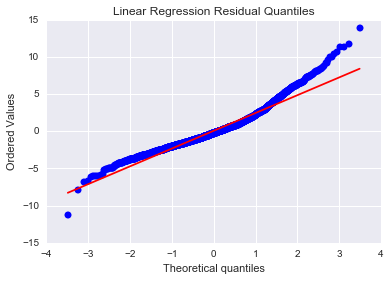

In [13]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

stats.probplot(lmresid['Rings'].values, dist='norm',plot=ax1)
ax1.set_title('Linear Regression Residual Quantiles')
plt.show()

This figure shows that the model residuals are not normally distributed - indicating there are higher order effects that the linear model is not capturing. This is an indication that a linear model just won't cut it.

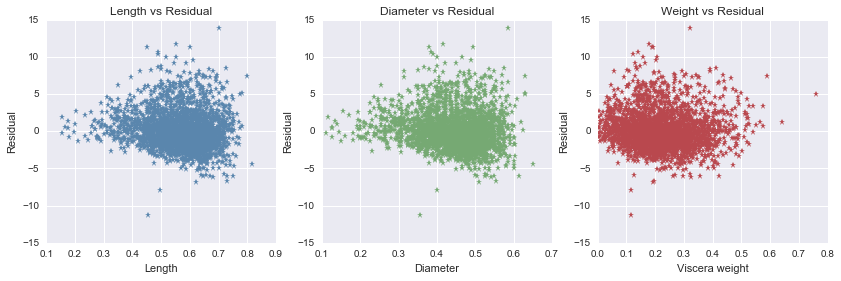

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

ax1.plot(adt_df['Length'],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty blue'])
ax1.set_xlabel('Length')
ax1.set_ylabel('Residual')
ax1.set_title('Length vs Residual')

ax2.plot(adt_df['Diameter'],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty green'])
ax2.set_xlabel('Diameter')
ax2.set_ylabel('Residual')
ax2.set_title('Diameter vs Residual')

ax3.plot(adt_df['Viscera weight'],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty red'])
ax3.set_xlabel('Viscera weight')
ax3.set_ylabel('Residual')
ax3.set_title('Weight vs Residual')

plt.show()

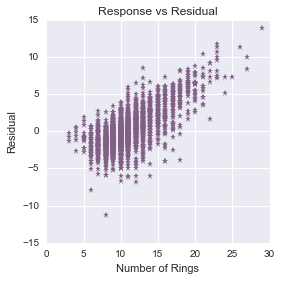

In [15]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))

ax1.plot(adt_df[ylabs],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty purple'])
ax1.set_xlabel('Number of Rings')
ax1.set_ylabel('Residual')
ax1.set_title('Response vs Residual')

plt.show()

This is a good illustration of why it's important to look at plots of residuals versus inputs and residuals versus response values. As both length and diameter get larger, the residuals also get larger, indicating there are higher-order effects with respect to length and diameter that are not accounted for in the model. (For example: suppose the number of rings is proportional to length squared, and the model treats the number of rings as proportional to length. Then as length gets larger, the (actual) number of rings will grow faster than our model predicts, causing residuals to grow larger as length grows larger.)

We can also see a stark dependence of the residual on the resopnse value. This indicates that a linear model does reassonably well for smaller, younger abalones, but does progressively worse as the abalones get older.

To lower the residual and improve our predictions, we'll either need to account for higher-order effects with length and diameter, or transform the variables.

<a name="scikit_linear_regresson_transformed"></a>
## scikit-learn: Linear Regression Residuals with Transformed Variables

Linear models for the response in terms of the factors (input variables) provided with the data set do not do a great job of predicting the number of rings. To improve the model, we can transform the variables we have into new variables, and try to improve the fit between the model and the data by using these derived quantities.

In a previous notebook, the product of length, diameter, and height gave us a "volume" of each abalone, correlated closely with the abalone's shell and viscera weight. Let's see if we can improve the results of the linear model by using the volume variable in our regression, either in place of or together with length, diameter, and height. Note that this is equivalent to adding an interaction term $x_1 x_2 x_3$ for the input variables $x_1$, $x_2$, $x_3$ (length, diameter, height).

In [16]:
print adt_df.columns

Index([u'Sex', u'Length', u'Diameter', u'Height', u'Whole weight',
       u'Shucked weight', u'Viscera weight', u'Shell weight', u'Rings',
       u'Volume'],
      dtype='object')


In [17]:
newxqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Volume']
print xqlabs
print newxqlabs

['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Volume']


In [18]:
lmxreg = linear_model.LinearRegression( fit_intercept = False )
lmxreg.fit( adt_df[newxqlabs], adt_df[ylabs] )

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [19]:
print lmreg.coef_
print lmxreg.coef_

[[  8.91404042  12.22048227  11.91342775   8.72210978 -21.56383663
  -12.44905461   6.33154266]]
[[   1.73633061   16.28024187   30.08527083   10.05883223  -19.51392789
    -8.98888089   10.1848586  -109.33040707]]


In [20]:
print lmxreg.score(adt_df[newxqlabs],adt_df[ylabs])

0.391937121154


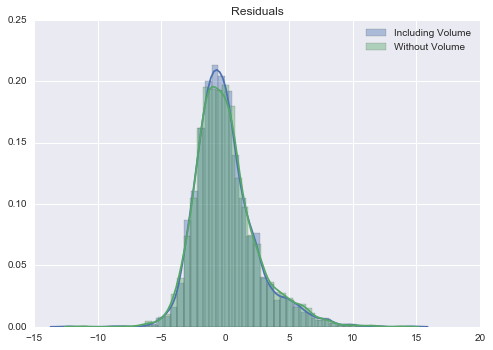

In [21]:
# Compute residuals 
yhatx = lmxreg.predict(adt_df[newxqlabs])
lmxresid = adt_df[ylabs] - yhatx
sns.distplot(lmxresid, label='Including Volume')
sns.distplot(lmresid,  label='Without Volume')
plt.title('Residuals')
plt.legend()
plt.show()

While adding a volume term did shift some of the residuals closer to 0 (raising the peak and lowering the tails), the volume term only improved the score of this linear model by a few points, indicating that this interaction term can't account for the variance in the residuals.

(Note that if we replace length, diameter, and height with the volume variable, rather than simply adding the volume variable to the linear regression, the residuals become significantly worse.)

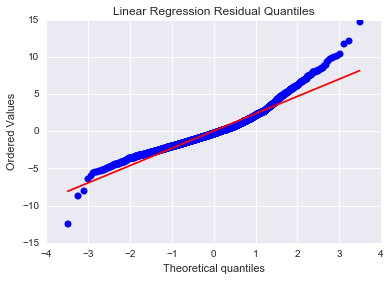

In [22]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

stats.probplot(lmxresid['Rings'].values, dist='norm',plot=ax1)
ax1.set_title('Linear Regression Residual Quantiles')
plt.show()

The distribution of residuals is still not normal (a sizeable portion of our points do not fall on the diagonal line), so the interaction term does not account for missing higher-order effects.

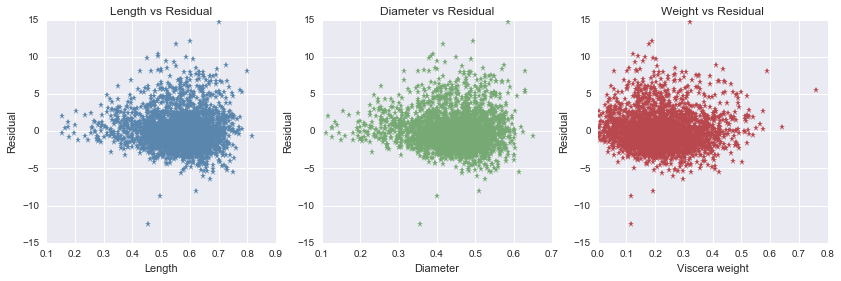

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

ax1.plot(adt_df['Length'],lmxresid['Rings'],'*', color=sns.xkcd_rgb['dusty blue'])
ax1.set_xlabel('Length')
ax1.set_ylabel('Residual')
ax1.set_title('Length vs Residual')

ax2.plot(adt_df['Diameter'],lmxresid['Rings'],'*', color=sns.xkcd_rgb['dusty green'])
ax2.set_xlabel('Diameter')
ax2.set_ylabel('Residual')
ax2.set_title('Diameter vs Residual')

ax3.plot(adt_df['Viscera weight'],lmxresid['Rings'],'*', color=sns.xkcd_rgb['dusty red'])
ax3.set_xlabel('Viscera weight')
ax3.set_ylabel('Residual')
ax3.set_title('Weight vs Residual')

plt.show()

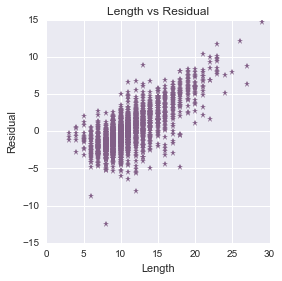

In [24]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))

ax1.plot(adt_df[ylabs],lmxresid['Rings'],'*', color=sns.xkcd_rgb['dusty purple'])
ax1.set_xlabel('Length')
ax1.set_ylabel('Residual')
ax1.set_title('Length vs Residual')

plt.show()

There is _still_ a functional dependence of residuals on length, diameter, and viscera weight, as well as on the response value. This tells us that the interaction term for length, diameter, and height will not account for the higher-order effects.

<a name="scikit_linear_regression_quadratic"></a>
## scikit-learn: Linear Regression Residuals with Quadratic Terms

It's clear we need higher order terms. Let's try adding some quadratic terms and see if that improves the model fit. Start by adding a few new variables - the square and square root of length, diameter, and height.

In [25]:
sqf = lambda x : x*x

adt_df.loc[:,'LengthSquared']   = adt_df['Length'].apply( sqf )
adt_df.loc[:,'DiameterSquared'] = adt_df['Diameter'].apply( sqf )
adt_df.loc[:,'HeightSquared']   = adt_df['Height'].apply( sqf )

In [26]:
quadratic_xqlabs = xqlabs + ['LengthSquared','DiameterSquared','HeightSquared']
print quadratic_xqlabs

quadratic_reg = linear_model.LinearRegression( fit_intercept = False )
quadratic_reg.fit( adt_df[quadratic_xqlabs], adt_df[ylabs] )

print quadratic_reg.score( adt_df[quadratic_xqlabs], adt_df[ylabs] )

['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'LengthSquared', 'DiameterSquared', 'HeightSquared']
0.4100404631


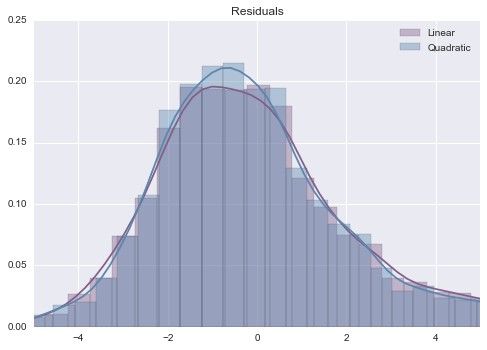

In [27]:
quadratic_yhat = quadratic_reg.predict(adt_df[quadratic_xqlabs])
quadratic_resid = adt_df[ylabs] - quadratic_yhat

sns.distplot(lmresid,         label='Linear',    color = sns.xkcd_rgb['dusty purple'])
sns.distplot(quadratic_resid, label='Quadratic', color = sns.xkcd_rgb['dusty blue'])

plt.title('Residuals')
plt.xlim([-5,5])
plt.legend()
plt.show()

Like adding a "Volume" term, adding quadratic terms to the model shifts the residuals closer to 0, shrinking the tails and raising the peak, but does not lead to significant improvements.

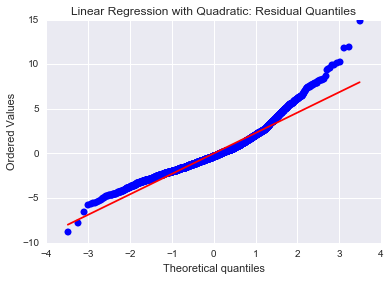

In [28]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

stats.probplot(quadratic_resid['Rings'].values, dist='norm',plot=ax1)
ax1.set_title('Linear Regression with Quadratic: Residual Quantiles')
plt.show()

The quantile plot shows that those quadratic terms have gotten us closer, at least - the three points on left are now _slight_ outliers instead of major outliers - but a quarter or more of our data still lies above the normal distribution line, so we still need a more complicated model.

<a name="scikit_ridge_regression"></a>
## scikit-learn: Ridge Regression

Ridge regression adds an objective to the optimization method that penalizes large regression coefficients and variable interactions. The idea is to reduce the number of dimensions as much as possible. As alpha gets larger, variance is reduced, but bias becomes higher. (This bias is called regularization.)

Based on some experimentation, the `fit_intercept=True` option, which adds a constant to the linear model being fit, leads to a better model fit. Additionally, alpha values less than 1 (making it closer to true linear regression) lead to slight improvements in model score.

In [29]:
rreg = linear_model.Ridge( alpha=0.1, fit_intercept=False )
rreg.fit(adt_df[xqlabs],adt_df[ylabs])

Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
print lmreg.coef_
print rreg.coef_

[[  8.91404042  12.22048227  11.91342775   8.72210978 -21.56383663
  -12.44905461   6.33154266]]
[[  9.32922993  11.7675061   11.4932108    8.31168588 -21.15602306
  -11.82394158   6.77249103]]


In [31]:
rresid = adt_df[ylabs] - rreg.predict(adt_df[xqlabs])

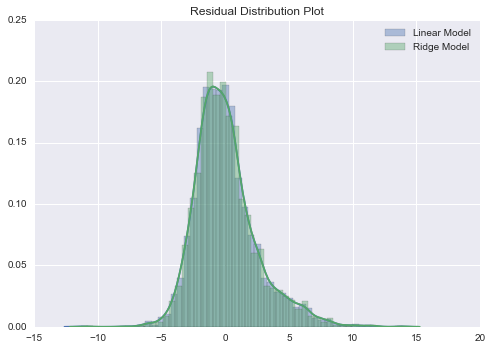

In [32]:
sns.distplot(lmresid, label='Linear Model')
sns.distplot(rresid, label='Ridge Model')
plt.title('Residual Distribution Plot')
plt.legend()
plt.show()

In [33]:
rreg.score(adt_df[xqlabs],adt_df[ylabs])

0.36158698143414691

Differences in residuals between the linear regression and ridge regression models are essentially zero. Ridge regression gets us nowhere closer to predicting the number of rings.

In [34]:
mse = np.mean( (rreg.predict(adt_df[xqlabs]) - adt_df[ylabs])**2 )
ybar = np.mean(adt_df[ylabs])
print "L2 residuals: %0.4f"%( np.sqrt(mse) )
print "Mean Response Level: %0.4f"%(ybar)

L2 residuals: 2.4519
Mean Response Level: 10.9009


<a name="statsmodel_linear_model"></a>
## StatsModel: Linear Regression Model

We can use the StatsModel library in Python to perform an ordinary least squares linear regression. This will give us the same results as the scikit-learn least squares model.

In [35]:
import statsmodels.api as sm

In [36]:
olm = sm.OLS(adt_df[ylabs], adt_df[xqlabs]).fit()
print olm.summary()

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     8215.
Date:                Sat, 07 Jan 2017   Prob (F-statistic):               0.00
Time:                        13:20:03   Log-Likelihood:                -6565.1
No. Observations:                2835   AIC:                         1.314e+04
Df Residuals:                    2828   BIC:                         1.319e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Length             8.9140      2.242      3.

In [37]:
print olm.params
print lmreg.coef_

Length             8.914040
Diameter          12.220482
Height            11.913428
Whole weight       8.722110
Shucked weight   -21.563837
Viscera weight   -12.449055
Shell weight       6.331543
dtype: float64
[[  8.91404042  12.22048227  11.91342775   8.72210978 -21.56383663
  -12.44905461   6.33154266]]


Both linear regression models (one from sklearn and the other from statsmodels) have matching coefficients. Good that the models match, but we haven't made any progress toward a better model. 

Unfortunately the statsmodel package doesn't implement a score functionality, so it's impossible to use scores to compare models from different packages.

<a name="lasso_regression"></a>
## scikit-learn: Lasso with Cross-Validation

Ridge regression attempts to _minimize_ the L2 norm of the regression coefficients for all variables (but does not necessarily let them go to 0). Lasso regression, however, is different - it can potentially set some regression coefficients to zero (ignoring the effect of a variable on the system response).

(Note: Lasso stands for least absolute shrinkage and selection operator. In this case, shrinkage refers to elminiation of variables.)

We can also use a Lasso model to try and fit the system response to the input variables, and see if this gives us any improvement in our residuals:

In [38]:
from sklearn.linear_model import LassoCV

In [39]:
## Option 1: 
## Specify an alpha
#lass = Lasso(random_state=0, alpha=0.5)
#lass = lass.fit( train_df[xqlabs], train_df[ylabs] )
#print lass.alpha

# Option 2: 
# Use a Lasso model with cross-validation 
# to optimize the value of alpha
lass = LassoCV(random_state=0)
lass = lass.fit( adt_df[xqlabs], adt_df[ylabs] )

print "LassoCV Model automatically selected the following value for alpha: %0.6f"%(lass.alpha_)

LassoCV Model automatically selected the following value for alpha: 0.002431


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
print lass.score( adt_df[xqlabs], adt_df[ylabs] )

0.393742353568


In [41]:
print xqlabs
print lass.coef_

['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
[  0.           3.59585288   4.01971746   8.10163174 -18.41438066
  -6.18645066  10.79485582]


The score tells us that we get very little improvement using the Lasso model with cross validation, compared to ordinary least squares or ridge regression. However, one particular result that is interesting is that the Lasso model set the length input variable's coefficient to 0.

In [42]:
lassyhat = lass.predict( adt_df[xqlabs] )
lassy = adt_df['Rings']
lassresid = lassy - lassyhat

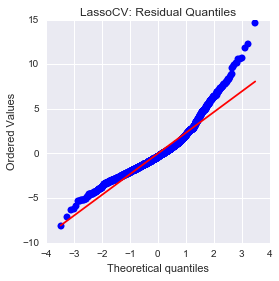

In [43]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

stats.probplot(lassresid, dist='norm', plot=ax1)

ax1.set_title('LassoCV: Residual Quantiles')

plt.show()

The Lasso regression didn't get us very far - but what if we add (independent) quadratic terms to the Lasso model?

In [44]:
lass2 = LassoCV(random_state=0)
lass2 = lass.fit( adt_df[quadratic_xqlabs], adt_df[ylabs] )
print "LassoCV Model automatically selected the following value for alpha: %0.6f"%(lass2.alpha_)
print lass2.score( adt_df[quadratic_xqlabs], adt_df[ylabs] )

LassoCV Model automatically selected the following value for alpha: 0.000455
0.408913351524


In [45]:
print quadratic_xqlabs
print lass2.coef_

['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'LengthSquared', 'DiameterSquared', 'HeightSquared']
[ 14.18124344   5.60456286  13.58652532   9.69061828 -18.89303643
  -8.37335852   9.64138407 -19.07147246  -0.          -9.94176515]


If we add quadratic terms for length, diameter, and height, it doesn't get us very far: the score improves by only a point or so, and the coefficent for the length input variable (which was previously 0) is now 14. This is an indication that the model is only supriously fitting the data. This conclusion is also borne out by the fact that the quantile plots of each linear model have deviated substantially from the red line, representing the normal distribution.

The fact that the optimal alpha values, computed using cross-validation, are all very tiny. 

In [46]:
lass2yhat = lass2.predict( adt_df[quadratic_xqlabs] )
lass2y = adt_df['Rings']
lass2resid = lass2y - lass2yhat

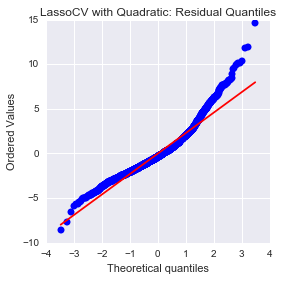

In [47]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

stats.probplot(lass2resid, dist='norm', plot=ax1)

ax1.set_title('LassoCV with Quadratic: Residual Quantiles')

plt.show()

Adding a quadratic term shifted some of the points to be slightly closer to the line, but overall the quadratic terms do very little to improve model predictions.

<a name="scikit_cross_validation"></a>
## scikit-learn: Cross Validation by Hand

The scikit-learn library also provides an object that can be used to perform cross-validation by hand and test the robustness of the estimated alpha parameter value.

Normally, a model like `LassoCV` performs cross-validation by splitting the data into a (large) training set and a (small) test set. The model then adjusts hyperparameters like $\alpha$ so that the best performance can be achieved (not sure how that is determined).

To use the `KFold` object from scikit-learn, which enables us to "fold" a vector at several places to form similarly-sized pieces, we can cut the vector in $N-1$ places using `KFold(N)`, and the resulting pieces are fed to the `LassoCV` model so it can perform its own cross-validation to determine the optimal value of alpha.

By folding the data ourselves, and passing different folds of data to the LassoCV model, we can take the $N$ pieces of our fold and rotate out which piece is used as the test set (the remaining data is used to train the model). This allows us to get a best-guess $\alpha$ value from the model. By performing this procedure on different folds of the data, we can get multiple alpha values and corresponding scores.

In [48]:
lasso_cv = LassoCV(random_state=0)
k_fold = KFold(3)

for k, (train, test) in enumerate(k_fold.split(adt_df[xqlabs], adt_df[ylabs])):
    lasso_cv.fit( adt_df[xqlabs].iloc[train], adt_df[ylabs].iloc[train] )
    
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k+1, lasso_cv.alpha_, lasso_cv.score( adt_df[xqlabs].iloc[test], adt_df[ylabs].iloc[test] )) )


[fold 1] alpha: 0.00333, score: 0.38488
[fold 2] alpha: 0.00046, score: 0.35154
[fold 3] alpha: 0.00124, score: 0.26222


Notes:
* I have very little idea about how to interpret these numbers - what does it mean if they're all about the same? What does it mean if they all increase, or decrease? What does it mean if one is a huge outlier?

<a name="lasso_lars_regression"></a>
## scikit-learn: Lasso Lars Regression

There is a variation on the Lasso regression procedure, a less aggressive procedure, called Lasso Lars regression. A Lasso Lars model uses the classic "forward selection" procedure, whereby the system response is regressed to a single variable, and the residuals computed. Those residuals are then used as the new system response, which are regressed to a second variable, and the new residuals computed, &c.

In this way, the "forward selection" process happens by regressing one input variable at a time. This approach is problematic because it tends to be greedy - meaning it can inadvertently attribute contributions to the response from an input vaariable $x_1$ that should have been attributed to $x_2$. 

Lasso Lars is less aggressive than the Lasso approach. 

In [49]:
lars = linear_model.LassoLars( alpha = 0.01, fit_intercept = False )
lars = lars.fit( adt_df[xqlabs], adt_df[ylabs] )
print lars.coef_
print lmreg.coef_

[ 13.87617852   8.14750654   2.06446954   2.8091537  -16.13423428   0.
  10.92616795]
[[  8.91404042  12.22048227  11.91342775   8.72210978 -21.56383663
  -12.44905461   6.33154266]]


In [50]:
print lars.score( adt_df[xqlabs], adt_df[ylabs] )
print lmreg.score( adt_df[xqlabs], adt_df[ylabs] )

0.333196729611
0.361672124059


In [51]:
larsyhat = lars.predict( adt_df[xqlabs] )
larsy = adt_df['Rings']
larsresid = larsy - larsyhat

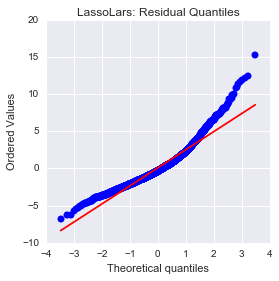

In [52]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

stats.probplot(larsresid, dist='norm', plot=ax1)

ax1.set_title('LassoLars: Residual Quantiles')

plt.show()

Like with other linear models tried so far, the residuals computed from the LassoLars regression have moved a bit with respect to the red line (representing a normal distribution) but has not changed the fact that the residuals are not normally distributed. As before, we can interpret this plot to mean that no linear model will be sufficient to make accurate predictions with this data.

<a name="scaling"></a>
## Scaling

Next we'll see what happens if we scale the input variables - and whether that leads to any improvement in how well the linear models can match our data.

In [53]:
from sklearn import preprocessing
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split( adt_df[xqlabs], adt_df[ylabs], test_size=0.4, random_state=1)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)

In [55]:
lmregn = linear_model.LinearRegression( fit_intercept = False )
lmregn.fit( X_train[xqlabs], y_train[ylabs] )
print lmregn.score(X_test,y_test)

0.358323405235


/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


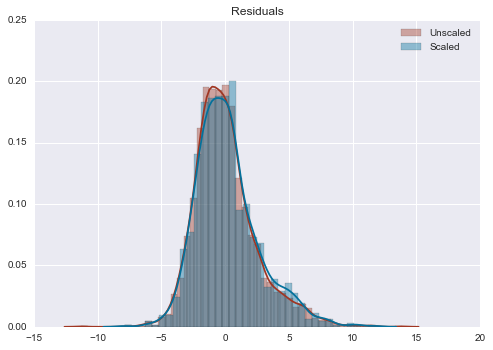

In [56]:
# Compute residuals 
yhat = lmregn.predict( X_test[xqlabs] )
lmresidn = y_test - yhat
sns.distplot(lmresid,  color=sns.xkcd_rgb['brick'], label='Unscaled')
sns.distplot(lmresidn, color=sns.xkcd_rgb['ocean blue'], label='Scaled')
plt.title('Residuals')
plt.legend()
plt.show()

Apparently, scaling the input variables leads to slightly _worse_ fits! The variance in the residuals increases slightly. As with all of the other attempts we've made to improve the fit of linear models, this step doesn't get us very far.

<a name="scikit_linear_svr"></a>
## scikit-learn: Linear Support Vector Regression

Support vector machines are models for classification of data; typically the responses are either binary or are integers. Support vector regression applies the same ideas and concepts to floating point responses.

In [57]:
from sklearn.svm import SVR

In [58]:
svr_lin = SVR(kernel='linear', C=1e4)
svr_lin = svr_lin.fit( adt_df[xqlabs], adt_df['Rings'].values )

In [59]:
print svr_lin.score(adt_df[xqlabs],adt_df['Rings'].values)

0.373155977736


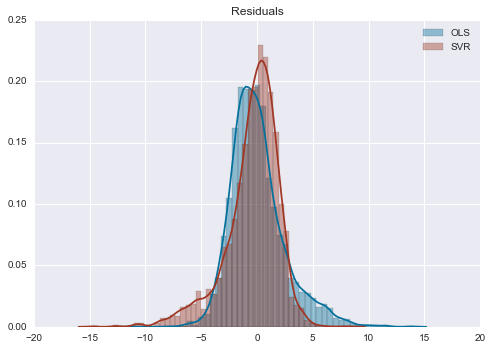

In [60]:
yhat = adt_df['Rings'].values
yhat_lin = svr_lin.predict(adt_df[xqlabs])

svresid = yhat_lin - yhat

sns.distplot(lmresid, color=sns.xkcd_rgb['ocean blue'], label='OLS')
sns.distplot(svresid,  color=sns.xkcd_rgb['brick'], label='SVR')

plt.title('Residuals')
plt.legend()
plt.show()

An interesting result! 

The state vector regression technique has eliminated some bias in the residuals, as evidenced by the peak of the residuals histogram being more closely centered at 0. However, a large group of negative outliers has cropped up as a result. If we look at the coefficients, we can see they are slightly different:

In [61]:
print svr_lin.coef_
print lmreg.coef_

[[ -3.69284789   6.68091811   8.50800478   9.00432672 -17.04983165
   -9.53431576   7.74145739]]
[[  8.91404042  12.22048227  11.91342775   8.72210978 -21.56383663
  -12.44905461   6.33154266]]


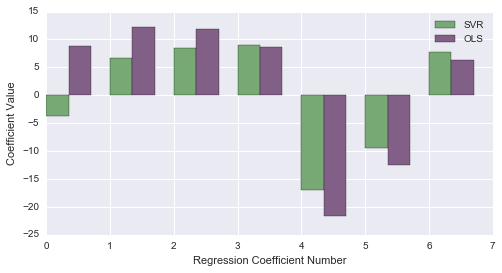

In [62]:
w = 0.35
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.bar(np.arange(len(svr_lin.coef_[0])), svr_lin.coef_[0], w, color=sns.xkcd_rgb['dusty green'],  label='SVR')
ax.bar(np.arange(len(lmreg.coef_[0]))+w,   lmreg.coef_[0], w, color=sns.xkcd_rgb['dusty purple'], label='OLS')
ax.legend(loc='best')
ax.set_xlabel('Regression Coefficient Number')
ax.set_ylabel('Coefficient Value')
plt.show()

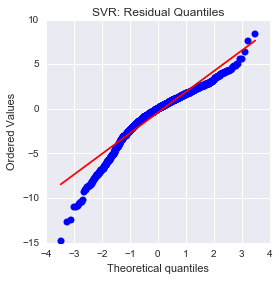

In [63]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

stats.probplot(svresid, dist='norm', plot=ax1)

ax1.set_title('SVR: Residual Quantiles')

plt.show()

The conclusion from this is the same as before: while SVR got us just a bit closer to a better model, it still couldn't get the job done - because it's still only a linear model, and still cannot capture higher order effects and variable interactions.

<a name="summary"></a>
## Summary

To recap: this notebook has demonstrated the construction and evaluation of several linear models. Each of these linear models assumed that the response was a linear function of each variable, and that the variables were all independent of one another. There were no interaction terms.

We also tried adding a few variables that were nonlinear, including a length-height-diameter interaction term and quadratic terms for length (only), height (only), and diameter (only). None of these approaches led to major improvements in the model's ability to fit data.

What do these results tell us? Each linear model had residuals that were not normally distributed, indicating there are higher-order interactions between these variables that need to be addressed.

In hindsight, this seems obvious. Of the seven quantitative variables in the original data set, four of the variables were different weights, which we expect to be linearly dependent. Three variables gave measurements and dimensions of the abalones, which we would also expect to be correlated (we would not expect, for example, the height and diameter of an abalone to be independent - if an abalone has a huge height and a very small diameter, it would indicate an erroneous data point sooner than it would indicate an unusual abalone).

<a name="next_steps"></a>
## Next Steps

The goal here is to come up with a function to predict the number of an abalone's rings as a function of these input variables. Because a linear model won't cut it, our next step is to add higher-order and nonlinear interaction terms.

We could potentially add nonlinear terms by hand, during preprocessing, as we were doing above (manually adding more columns to the DataFrame and evaluating the fit with each new variable). But this is very labor-intensive, and we have many, many, many combinations to try (what if we need a fourth-order or fifth-order polynomial?).

This is where SVR (state vector regression) will come in handy. We can specify different kinds of kernel functions, and the SVR model will automatically determine the best form of the kernel function for our data. (For example, if we specify a third-degree polynomial, we won't have to compute all of these effects by hand and compare them to pick out the best; SVR does this through its optimization process.) 